# fig8_prec
AR composites of daily precipitation (mm/day)


## Imports

In [1]:
# Standard Python modules
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text 
rcParams['font.family'] = 'sans-serif'   # font family = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # default sans-serif font = 'Arial'


## Data

In [25]:
plot_dict_non_anom = {'fname': 'ERA5/prec/daily/out.era5_hma_025dg_daily_prec_*.nc',
                      'clevs_prec': np.arange(2,22,2),
                      'cmap_prec': cmo.rain,
                      'fig_name_prefix': 'ar_types_prec_'}

plot_dict_anom = {'fname': 'ERA5/prec/anomalies/daily_filtered_anomalies_*.nc',
                  'clevs_prec': np.arange(-6,22,2),
                  'cmap_prec': cmocean.tools.crop(cmo.balance, vmin=-6., vmax=22., pivot=0., N=None, dmax=None),
                  'fig_name_prefix': 'anom_ar_types_prec_'}

plot_dict = plot_dict_anom

### ERA5 renalysis


In [5]:
# Select lat/lon grid 
lonmin = 40.
lonmax = 120
latmin = 10.
latmax = 50.

def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

# open HUV anomaly data
filepath_pattern = path_to_data + plot_dict['fname']
    
    
f2 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')
# f2

# Create new dataset to rename lat lon
ds = xr.Dataset({'prec': (['time', 'lat', 'lon'], f2['mtpr'].values*86400)},
                      coords={'time': (['time'], f2.time.values),
                              'lat': (['lat'], f2.latitude.values),
                              'lon': (['lon'], f2.longitude.values)})

ds
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))


ds size in GB 6.04



### AR days

In [6]:
fname_id = 'HUV500t0120050cor'
filepath = path_to_out + fname_id + 'hma_AR-types-djf.csv'
df = pd.read_csv(filepath)

In [7]:
# Trim date range
start_date = '1979-12-01'
end_date = '2018-02-28'
idx = slice(start_date, end_date)
ds = ds.sel(time=idx)

# Select DJF months
idx = (ds.time.dt.month >= 12) | (ds.time.dt.month <= 2)
ds = ds.sel(time=idx)

# Combine AR Cat data w/ reanalysis data
# Add ar time series to the ERA dataset
ds['ar'] = ('time', df.AR_CAT)
ds = ds.set_coords('ar')

In [8]:
def select_ar_days(era, lag=0):
    # Select only AR days
    idx = (era.ar >= 1)
    # select days with lag shift
    era_ar = era.shift(time=lag).sel(time=idx)
    # print results
    print(era_ar)
    
    return era_ar

# Lag=0, -2, +2
era_ar_lag0 = select_ar_days(era=ds, lag=0)
era_ar_lag2 = select_ar_days(era=ds, lag=-2)
era_ar_lead2 = select_ar_days(era=ds, lag=2)

<xarray.Dataset>
Dimensions:  (lat: 161, lon: 321, time: 371)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-26T09:00:00
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 10.75 10.5 10.25 10.0
  * lon      (lon) float32 40.0 40.25 40.5 40.75 ... 119.25 119.5 119.75 120.0
    ar       (time) int64 3 3 1 3 3 2 3 3 3 2 1 3 3 ... 3 3 3 3 3 3 3 1 1 2 2 2
Data variables:
    prec     (time, lat, lon) float64 2.078 1.803 0.898 ... 19.38 15.94 13.51
<xarray.Dataset>
Dimensions:  (lat: 161, lon: 321, time: 371)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-26T09:00:00
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 10.75 10.5 10.25 10.0
  * lon      (lon) float32 40.0 40.25 40.5 40.75 ... 119.25 119.5 119.75 120.0
    ar       (time) int64 3 3 1 3 3 2 3 3 3 2 1 3 3 ... 3 3 3 3 3 3 3 1 1 2 2 2
Data variables:
    prec     (time, lat, lon) float64 -0.9622 -1.0 -0.9586 ... -1.271 -0.3212
<xarray.Dataset>
Dimension

### Composites of AR types

In [9]:
# Compute composites of each AR type
era_ar_comp_lag0 = era_ar_lag0.groupby('ar').mean('time')
era_ar_comp_lag2 = era_ar_lag2.groupby('ar').mean('time')
era_ar_comp_lead2 = era_ar_lead2.groupby('ar').mean('time')

# combine lag datasets into 1 ds object
era_ar_comp = xr.concat([era_ar_comp_lead2, era_ar_comp_lag0, era_ar_comp_lag2], pd.Index([-2, 0, 2], name='lag'))
era_ar_comp


<xarray.Dataset>
Dimensions:  (ar: 3, lag: 3, lat: 161, lon: 321)
Coordinates:
  * ar       (ar) int64 1 2 3
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 10.75 10.5 10.25 10.0
  * lon      (lon) float32 40.0 40.25 40.5 40.75 ... 119.25 119.5 119.75 120.0
  * lag      (lag) int64 -2 0 2
Data variables:
    prec     (lag, ar, lat, lon) float64 -0.1626 -0.2041 ... -1.402 -1.573

## Figure 8

### Common plot properties

In [10]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)


### Create figure

In [11]:
# lat/lon arrays
lats = era_ar_comp.lat.values
lons = era_ar_comp.lon.values

# precip
prec = era_ar_comp.prec.values
print(prec.min(), prec.max())

# Labels
plt_labels = ['AR Type 1', 'AR Type 2', 'AR Type 3']

-15.980999310727965 21.435357984935322


-2.33135515444525 7.854699966079017
-3.3860316830270647 4.151702207502321
-4.324092185582203 17.081685721695454
-2.0998715788136617 21.435357984935322
-5.127546170551814 17.320899760741423
-15.980999310727965 13.898188145334046
-4.918990977677144 10.13507866933431
-4.048783216069527 9.351153050119372
-7.547704656777194 15.381508002722521


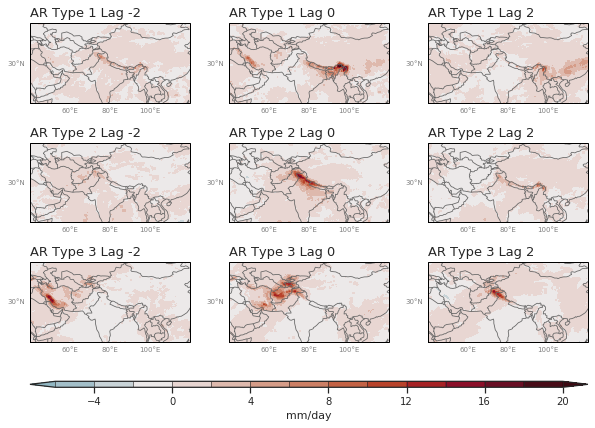

In [26]:
# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 3
ncols = 3

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.0, cbar_size='2.5%',label_mode='',
                direction='column')

# loop to draw plots
lag_lst = [-2, -2, -2, 0, 0, 0, 2, 2, 2]
artype_lst = [1, 2, 3, 1, 2, 3, 1, 2, 3]
for k, (ax, lag, ar_type) in enumerate(zip(axgr, lag_lst, artype_lst)):
    data = era_ar_comp.sel(lag=lag, ar=ar_type)
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values 
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Precip (filled contour)
    prec = data.prec.values
    print(prec.min(), prec.max())
    cf = ax.contourf(lons, lats, prec, transform=datacrs,
                    levels=plot_dict['clevs_prec'],cmap=plot_dict['cmap_prec'], extend='both')
    
   # subtitles
    plt_label = 'AR Type {0} Lag {1}'.format(ar_type, lag)
    ax.set_title(plt_label, loc='left',fontsize=13)

    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('mm/day', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Save figure
filepath = path_to_figs + plot_dict['fig_name_prefix']+ fname_id + '.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()
    

### Composite EOF using Std Dev

In [18]:
# precip
prec = era_eof_comp.prec.values
print(prec.min(), prec.max())

# Labels
plt_labels = ['AR EOF 1', 'AR EOF 2']

-4.296742596672577e-06 22.838704635326128


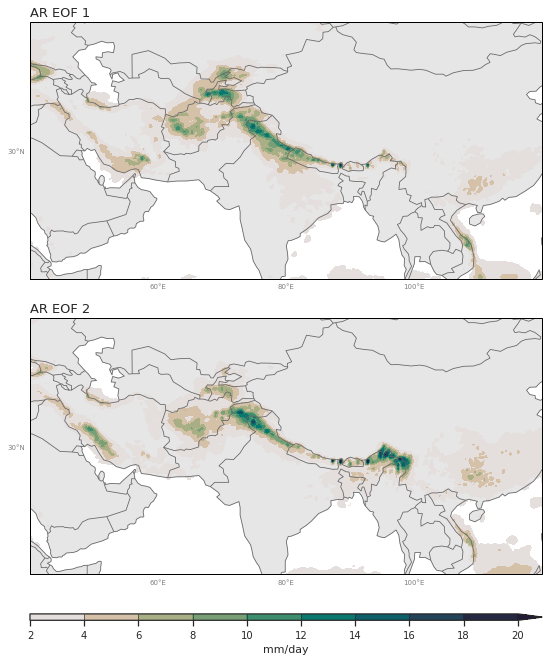

In [19]:
# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 2
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.0, cbar_size='2.5%',label_mode='')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Precip (filled contour)
    clevs = np.arange(2,22,2)
    cf = ax.contourf(lons, lats, prec[k,:,:], transform=datacrs,
                    levels=clevs,cmap=cmo.rain, extend='max')
    
    # Subtitles
    ax.set_title(plt_labels[k], loc='left', fontsize=13)

    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('mm/day', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Save figure
filepath = path_to_figs + 'eof_types_'+ fname_id + '.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()
    